In [381]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [408]:
file_path='data\smart dataset sample.csv'
df=pd.read_csv(file_path)
data=df.iloc[:,3:]
X=data.iloc[:,1:]
Y=data.iloc[:,0]

smart_5_raw     NaN
smart_187_raw   NaN
smart_188_raw   NaN
smart_197_raw   NaN
smart_198_raw   NaN
smart_9_raw     NaN
smart_193_raw   NaN
smart_194_raw   NaN
smart_241_raw   NaN
smart_242_raw   NaN
Name: 1954, dtype: float64

# 数据探索

In [383]:
print('failure num: ',len(df.groupby('failure').groups[0]))
print('healthy num: ',len(df.groupby('failure').groups[1]))

failure num:  5518
healthy num:  5518


In [512]:
def hist_attribute(df,bin=150):
    '''查看特征的分布情况如何'''
    plt.figure(figsize=[20,25])
    plt.title('feature distribution')
    for i in range(len(df.columns)):
        title=df.columns[i]
        plt.subplot(5,2,i+1)
        plt.hist(df.iloc[:,i].values,bins=bin)
        plt.title(title)
        plt.xlabel('value')
        plt.ylabel('count')

'感觉基本上就5个特征是有用的'

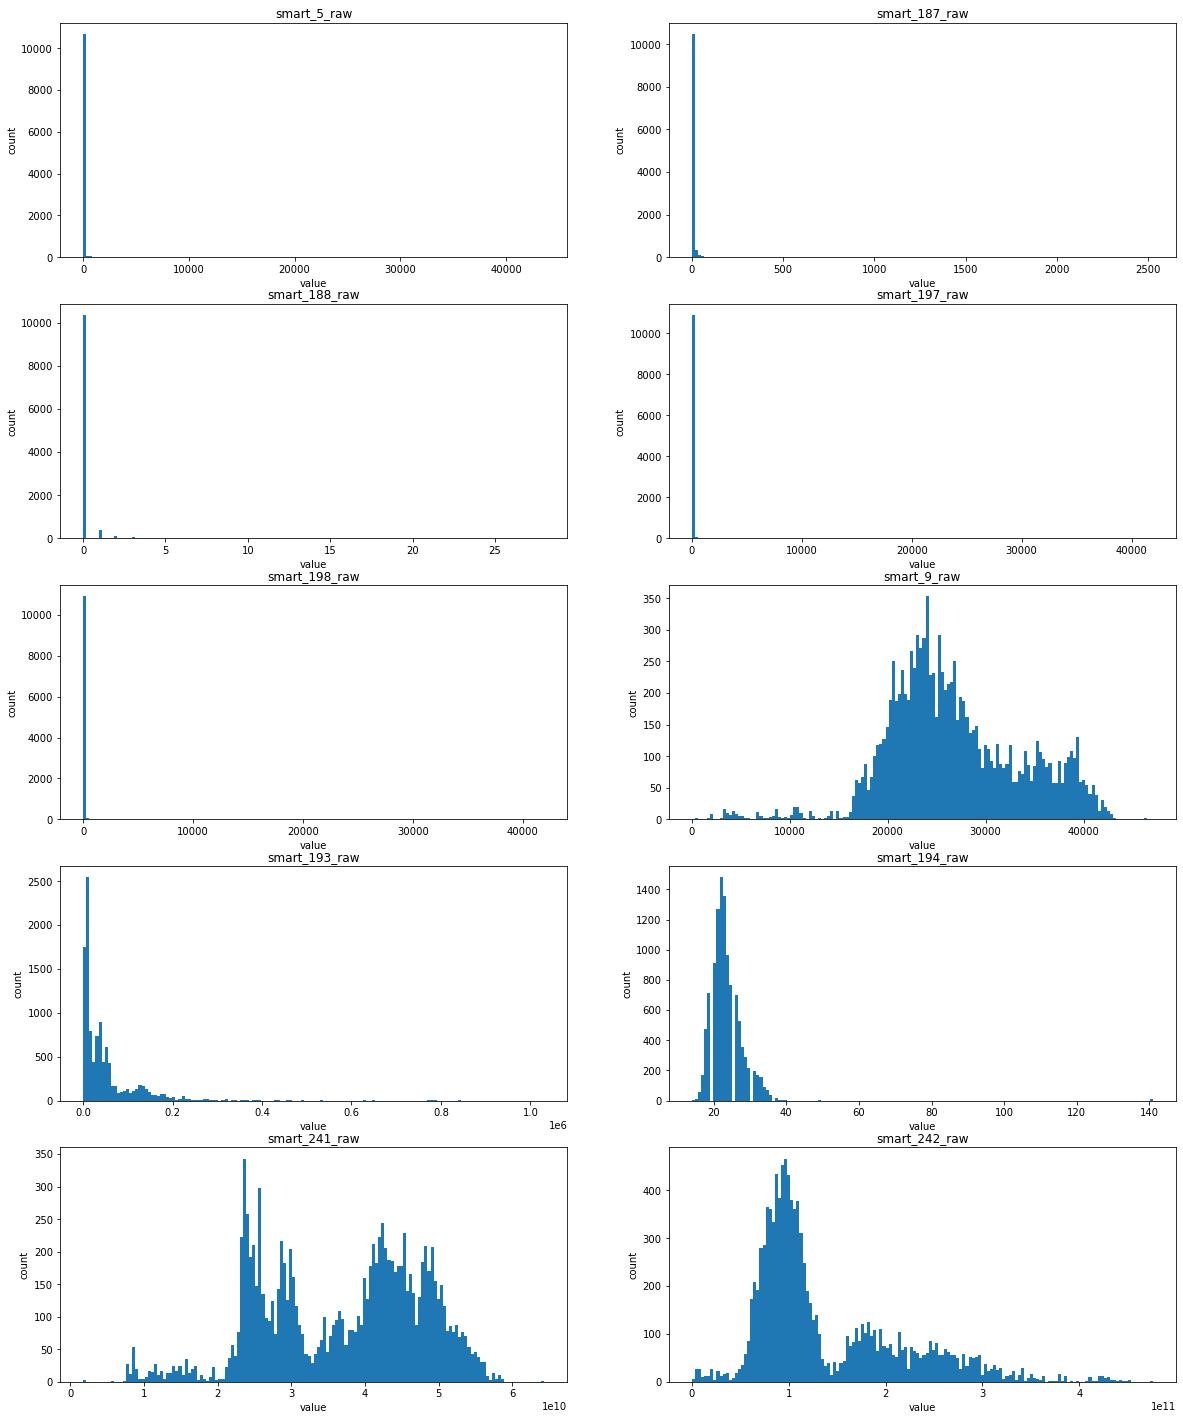

In [385]:
hist_attribute(data.iloc[:,1:])
'''感觉基本上就5个特征是有用的'''

In [386]:
# 准备选用的特征集合
feature_set=list(data.columns[6:])
feature_set

['smart_9_raw',
 'smart_193_raw',
 'smart_194_raw',
 'smart_241_raw',
 'smart_242_raw']

# 填补空值

In [404]:
# 除去一些没啥用的特征
X.drop(X.columns.difference(feature_set),axis=1, inplace=True)
# 删去特征全为空的样本
X.dropna(how='all',inplace=True)
Y=Y.iloc[X.index]
X=X.reset_index(drop=True)
Y=Y.reset_index(drop=True)

In [390]:
# 检查每一行是否有元素为0
X[(X==0).any(1)]
# X的每一行的值都不为0

,smart_9_raw,smart_193_raw,smart_194_raw,smart_241_raw,smart_242_raw


# 特征处理

## 对数优化

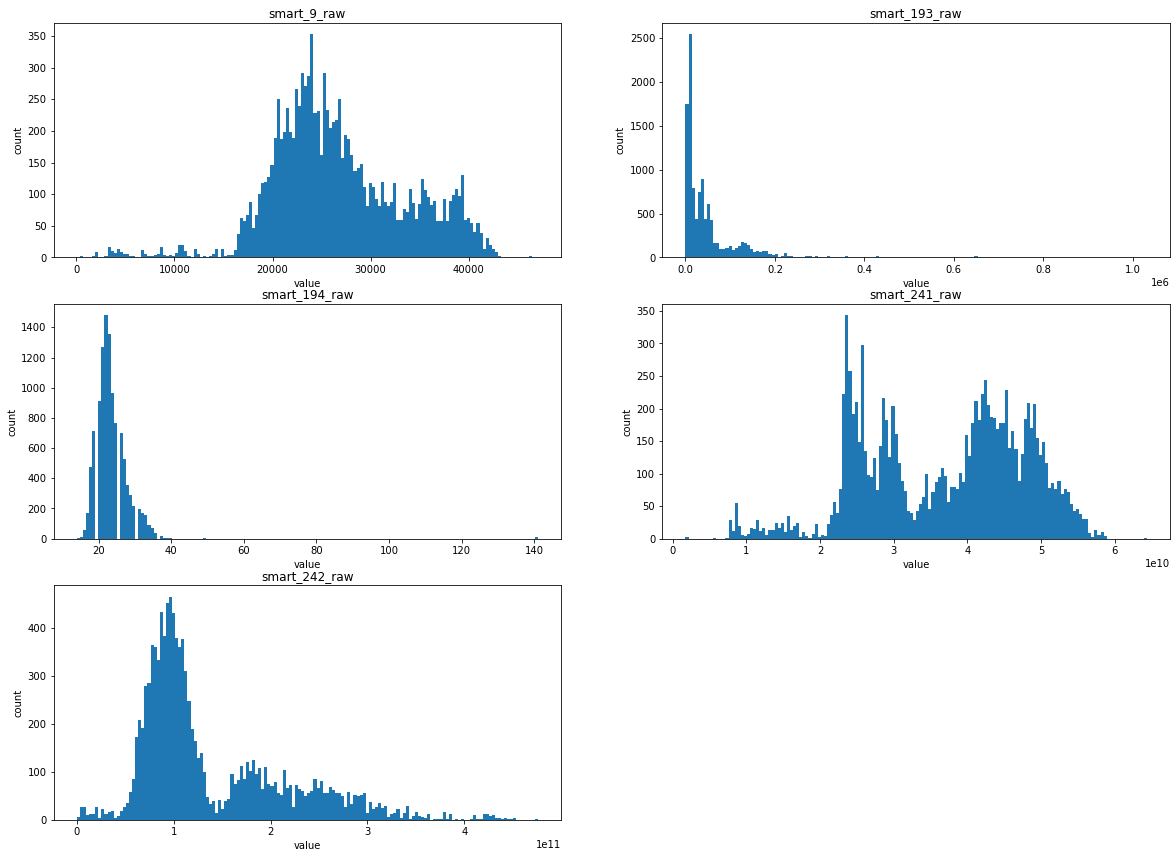

In [391]:
hist_attribute(X)

我们可以看到，特征'smart_193_row'有一些倾斜，我们对它取对数看看

In [392]:
X_modify=X.copy()
X_modify['smart_193_raw']=X['smart_193_raw'].apply(np.log)

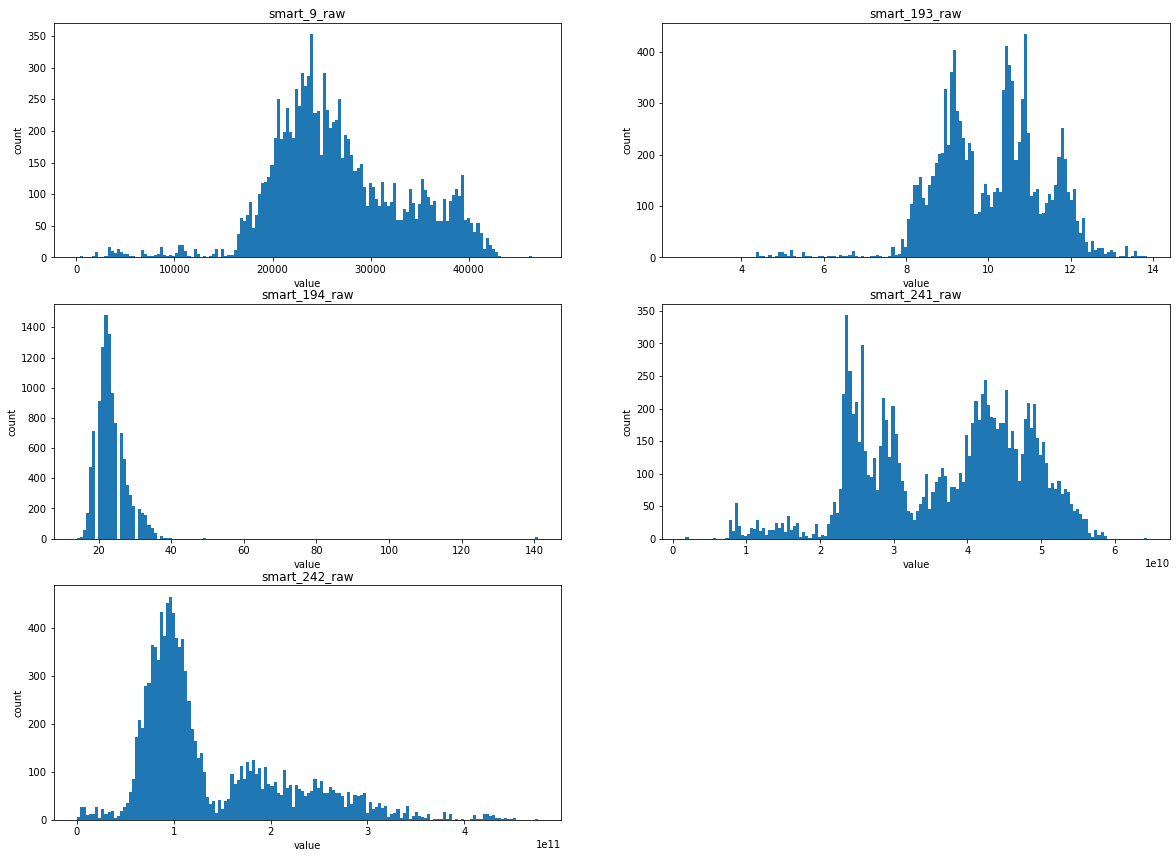

In [393]:
hist_attribute(X_modify)

## 归一化

In [394]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

ss=StandardScaler()
ms=MinMaxScaler()

# 对log优化后的数据进行归一化和标准化
X_modify_ss=ss.fit_transform(X_modify)
X_modify_ms=ms.fit_transform(X_modify)

# 对原始数据进行归一化和标准化
X_ss=ss.fit_transform(X_modify)
X_ms=ms.fit_transform(X_modify)

Y=np.array(Y.values).reshape(-1,1)

# 数据整理完毕，分割数据集

In [395]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_ss,Y,test_size=0.3,stratify=Y)

In [523]:
# 降维可视化一下数据
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib inline

def plot_pca(num=3,data=X_train,label=y_train):
    pca=PCA(n_components=num)
    X_pca=pca.fit_transform(data)
    # 分割数据
    X_failure=np.array([x for i,x in enumerate(X_pca) if label[i][0]==1])
    X_healthy=np.array([x for i,x in enumerate(X_pca) if label[i][0]==0])
    
    if num==3:
        fig = plt.figure()
        ax = Axes3D(fig)   
        #ax.legend(loc='best')
        ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
        ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
        ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
        ax.scatter(X_failure[:,0], X_failure[:,1], X_failure[:,2])
        ax.scatter(X_healthy[:,0], X_healthy[:,1], X_healthy[:,2])
    elif num==2:
        plt.figure(figsize=[10,10])
        plt.scatter(X_failure[:,0],X_failure[:,1])
        plt.scatter(X_healthy[:,0],X_healthy[:,1])
    else:
        print('i do not want to work.....')


def plot_lda(num=3,data=X_train,label=y_train):
    lda = LinearDiscriminantAnalysis(n_components=num)
    X_pca=lda.fit_transform(data,label)
    # 分割数据
    X_failure=np.array([x for i,x in enumerate(X_pca) if y_train[i][0]==1])
    X_healthy=np.array([x for i,x in enumerate(X_pca) if y_train[i][0]==0])
    
    if num==3:
        fig = plt.figure()
        ax = Axes3D(fig)   
        #ax.legend(loc='best')
        ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
        ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
        ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
        ax.scatter(X_failure[:,0], X_failure[:,1], X_failure[:,2])
        ax.scatter(X_healthy[:,0], X_healthy[:,1], X_healthy[:,2])
    elif num==2:
        plt.figure(figsize=[10,10])
        plt.scatter(X_failure[:,0],X_failure[:,1])
        plt.scatter(X_healthy[:,0],X_healthy[:,1])
    else:
        print('i do not want to work.....')

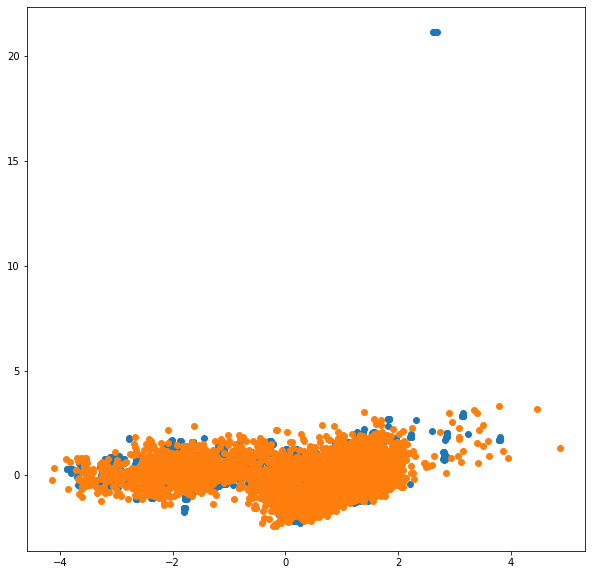

In [397]:
plot_pca(num=2)

In [398]:
# 开始分类
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings("ignore")

clf_1 = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
clf_2 = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
clf_3 = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

scores1 = cross_val_score(clf_1, X_ms, Y, cv=5)
scores2 = cross_val_score(clf_2, X_ms, Y, cv=5)
scores3 = cross_val_score(clf_3, X_ms, Y, cv=5)

print('RandomForestClassifier scores: ',scores1.mean())
print('DecisionTreeClassifier scores: ',scores2.mean())
print('ExtraTreesClassifier scores: ',scores3.mean())

RandomForestClassifier scores:  0.5241504304485727
DecisionTreeClassifier scores:  0.53212505663797
ExtraTreesClassifier scores:  0.5196193928409606


# 我发现，我的分类器准确性小的可怜.....
##  后来我发现，原来一开始的特征图上的前五个特征不是数据方差太小，而是因为空值太多
##  于是为了改善模型，我将尝试填补这些特征的空值

# 空值填补

## 重新设计数据集

In [537]:
file_path='data\smart dataset sample.csv'
df=pd.read_csv(file_path)
data=df.iloc[:,3:]
X=data.iloc[:,1:]
Y=data.iloc[:,0]

# 删去特征全为空的样本
X.dropna(how='all',inplace=True)
Y=Y.iloc[X.index]

X=X.reset_index(drop=True)
Y=Y.reset_index(drop=True)

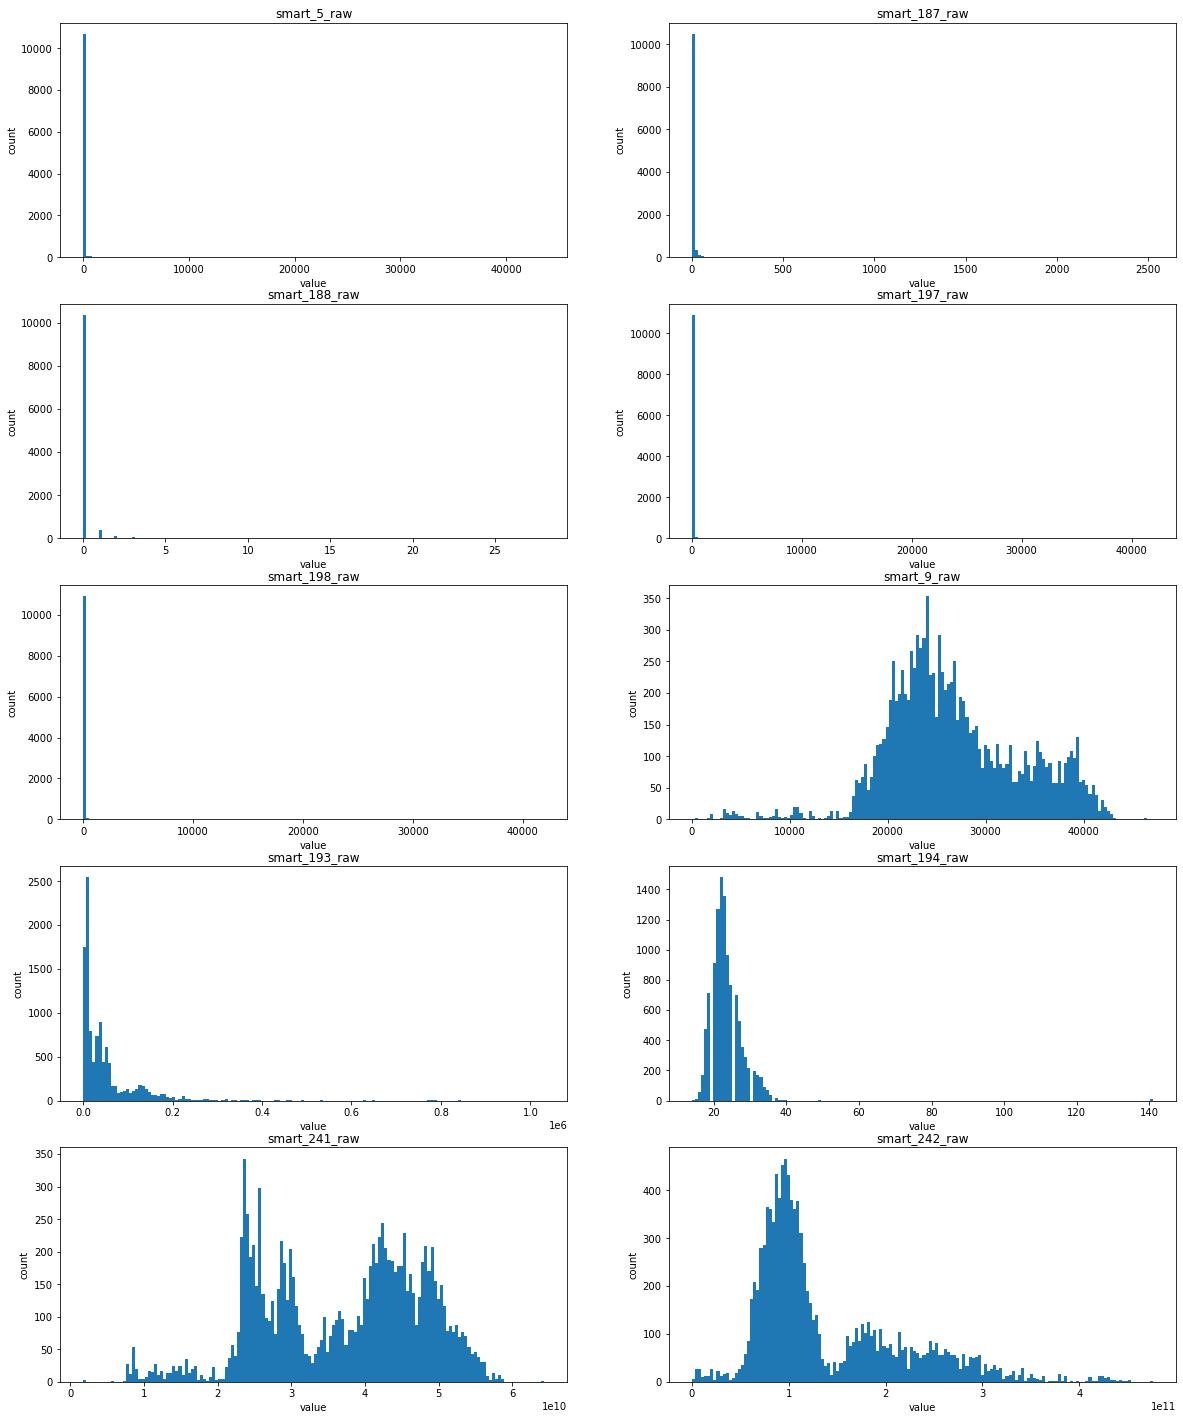

In [412]:
hist_attribute(X)

## 试试简单的填补空缺值的方法

In [538]:
# KNN回归填补空缺值
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor

def knn_missing_filled(train_x,train_y,test,k=3,dispersed=True):
    if dispersed:
        clf=KNeighborsClassifier(n_neighbors=k,weights='distance',n_jobs=-1)
    else:
        clf=KNeighborsRegressor(n_neighbors=k,weights='distance',n_jobs=-1)
    clf.fit(train_x,train_y)
    return test.index,clf.predict(test)

# 测试-------------------------------------------------------------------
### 从后往前填补特征

In [504]:
# smart_198_raw的数据集
data_knn=X.iloc[:,4:]
# 训练集
data_knn_train=data_knn[data_knn['smart_198_raw']!=0]
# 测试集
data_knn_test=data_knn[data_knn['smart_198_raw']==0]

In [482]:
# 检查训练集每一行是否有元素为0
data_knn_train[(data_knn_train==0).any(1)]
# 训练集的每一行的值都不为0

,smart_198_raw,smart_9_raw,smart_193_raw,smart_194_raw,smart_241_raw,smart_242_raw


In [483]:
# 检查测试集每一行是否有元素为0
data_knn_train.iloc[:,1:][(data_knn_train.iloc[:,1:]==0).any(1)]
# 测试集的每一行的值都不为0

,smart_9_raw,smart_193_raw,smart_194_raw,smart_241_raw,smart_242_raw


In [487]:
# 训练集
X_knn_train=data_knn_train.iloc[:,1:]
y_knn_train=data_knn_train.iloc[:,0]
# 测试集
X_knn_test=data_knn_test.iloc[:,1:]
# 预测
ind,pred_knn=knn_missing_filled(X_knn_train,y_knn_train,X_knn_test)

In [493]:
X.loc[ind,'smart_198_raw']=pred_knn
X

,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_9_raw,smart_193_raw,smart_194_raw,smart_241_raw,smart_242_raw
0,0.0,0.0,0.0,0.0,8.0,26665.0,34262.0,20.0,4.398957e+10,1.341200e+11
1,0.0,0.0,2.0,0.0,48.0,37085.0,151921.0,24.0,2.643057e+10,2.748650e+11
2,0.0,0.0,0.0,0.0,24.0,31758.0,40089.0,21.0,5.465423e+10,1.047500e+11
3,0.0,16.0,1.0,56.0,56.0,31713.0,38454.0,16.0,5.761638e+10,1.059560e+11
4,1856.0,32.0,0.0,8.0,8.0,34132.0,55556.0,19.0,5.624616e+10,1.117940e+11
...,...,...,...,...,...,...,...,...,...,...
11030,0.0,4.0,0.0,0.0,104.0,16921.0,2487.0,35.0,3.888814e+10,7.081230e+10
11031,0.0,0.0,0.0,0.0,1024.0,35492.0,18589.0,22.0,3.063053e+10,2.637790e+11
11032,0.0,0.0,0.0,0.0,152.0,28148.0,85923.0,20.0,2.662399e+10,2.453300e+11
11033,0.0,0.0,0.0,40.0,40.0,39123.0,198197.0,22.0,3.419042e+10,3.719780e+11


In [502]:
X.iloc[:,0:]

,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_9_raw,smart_193_raw,smart_194_raw,smart_241_raw,smart_242_raw
0,0.0,0.0,0.0,0.0,8.0,26665.0,34262.0,20.0,4.398957e+10,1.341200e+11
1,0.0,0.0,2.0,0.0,48.0,37085.0,151921.0,24.0,2.643057e+10,2.748650e+11
2,0.0,0.0,0.0,0.0,24.0,31758.0,40089.0,21.0,5.465423e+10,1.047500e+11
3,0.0,16.0,1.0,56.0,56.0,31713.0,38454.0,16.0,5.761638e+10,1.059560e+11
4,1856.0,32.0,0.0,8.0,8.0,34132.0,55556.0,19.0,5.624616e+10,1.117940e+11
...,...,...,...,...,...,...,...,...,...,...
11030,0.0,4.0,0.0,0.0,104.0,16921.0,2487.0,35.0,3.888814e+10,7.081230e+10
11031,0.0,0.0,0.0,0.0,1024.0,35492.0,18589.0,22.0,3.063053e+10,2.637790e+11
11032,0.0,0.0,0.0,0.0,152.0,28148.0,85923.0,20.0,2.662399e+10,2.453300e+11
11033,0.0,0.0,0.0,40.0,40.0,39123.0,198197.0,22.0,3.419042e+10,3.719780e+11


In [507]:
X

,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_9_raw,smart_193_raw,smart_194_raw,smart_241_raw,smart_242_raw
0,0.0,0.0,0.0,0.0,0.0,26665.0,34262.0,20.0,4.398957e+10,1.341200e+11
1,0.0,0.0,2.0,0.0,0.0,37085.0,151921.0,24.0,2.643057e+10,2.748650e+11
2,0.0,0.0,0.0,0.0,0.0,31758.0,40089.0,21.0,5.465423e+10,1.047500e+11
3,0.0,16.0,1.0,56.0,56.0,31713.0,38454.0,16.0,5.761638e+10,1.059560e+11
4,1856.0,32.0,0.0,8.0,8.0,34132.0,55556.0,19.0,5.624616e+10,1.117940e+11
...,...,...,...,...,...,...,...,...,...,...
11030,0.0,4.0,0.0,0.0,0.0,16921.0,2487.0,35.0,3.888814e+10,7.081230e+10
11031,0.0,0.0,0.0,0.0,0.0,35492.0,18589.0,22.0,3.063053e+10,2.637790e+11
11032,0.0,0.0,0.0,0.0,0.0,28148.0,85923.0,20.0,2.662399e+10,2.453300e+11
11033,0.0,0.0,0.0,40.0,40.0,39123.0,198197.0,22.0,3.419042e+10,3.719780e+11


# -------------------------------------------------------------------

In [539]:
# 一次性填补完所有特征
def fill_feature_knn(X_):
    # 待填充的特征
    features=['smart_5_raw','smart_187_raw','smart_188_raw','smart_197_raw','smart_198_raw']
    for i in reversed(range(len(features))):
        # smart_198_raw的数据集
        data_knn=X_.iloc[:,i:]# 完整数据（包括待预测的label）
        fea=features[i]# 待填补特征
        data_knn_train=data_knn[data_knn[fea]!=0]# 训练集
        data_knn_test=data_knn[data_knn[fea]==0]# 测试集
        # 训练集
        X_knn_train=data_knn_train.iloc[:,1:]
        y_knn_train=data_knn_train.iloc[:,0]
        # 测试集
        X_knn_test=data_knn_test.iloc[:,1:]
        # 预测
        ind,pred_knn=knn_missing_filled(X_knn_train,y_knn_train,X_knn_test)
        # 填补
        X_.loc[ind,fea]=pred_knn
    return X_

In [540]:
X=fill_feature_knn(X)

In [541]:
X

,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_9_raw,smart_193_raw,smart_194_raw,smart_241_raw,smart_242_raw
0,8.0,3.0,3.0,8.0,8.0,26665.0,34262.0,20.0,4.398957e+10,1.341200e+11
1,11248.0,30.0,2.0,48.0,48.0,37085.0,151921.0,24.0,2.643057e+10,2.748650e+11
2,8.0,9.0,1.0,24.0,24.0,31758.0,40089.0,21.0,5.465423e+10,1.047500e+11
3,336.0,16.0,1.0,56.0,56.0,31713.0,38454.0,16.0,5.761638e+10,1.059560e+11
4,1856.0,32.0,1.0,8.0,8.0,34132.0,55556.0,19.0,5.624616e+10,1.117940e+11
...,...,...,...,...,...,...,...,...,...,...
11030,8.0,4.0,1.0,104.0,104.0,16921.0,2487.0,35.0,3.888814e+10,7.081230e+10
11031,22960.0,2.0,1.0,1024.0,1024.0,35492.0,18589.0,22.0,3.063053e+10,2.637790e+11
11032,8.0,6.0,1.0,152.0,152.0,28148.0,85923.0,20.0,2.662399e+10,2.453300e+11
11033,26056.0,42.0,3.0,40.0,40.0,39123.0,198197.0,22.0,3.419042e+10,3.719780e+11


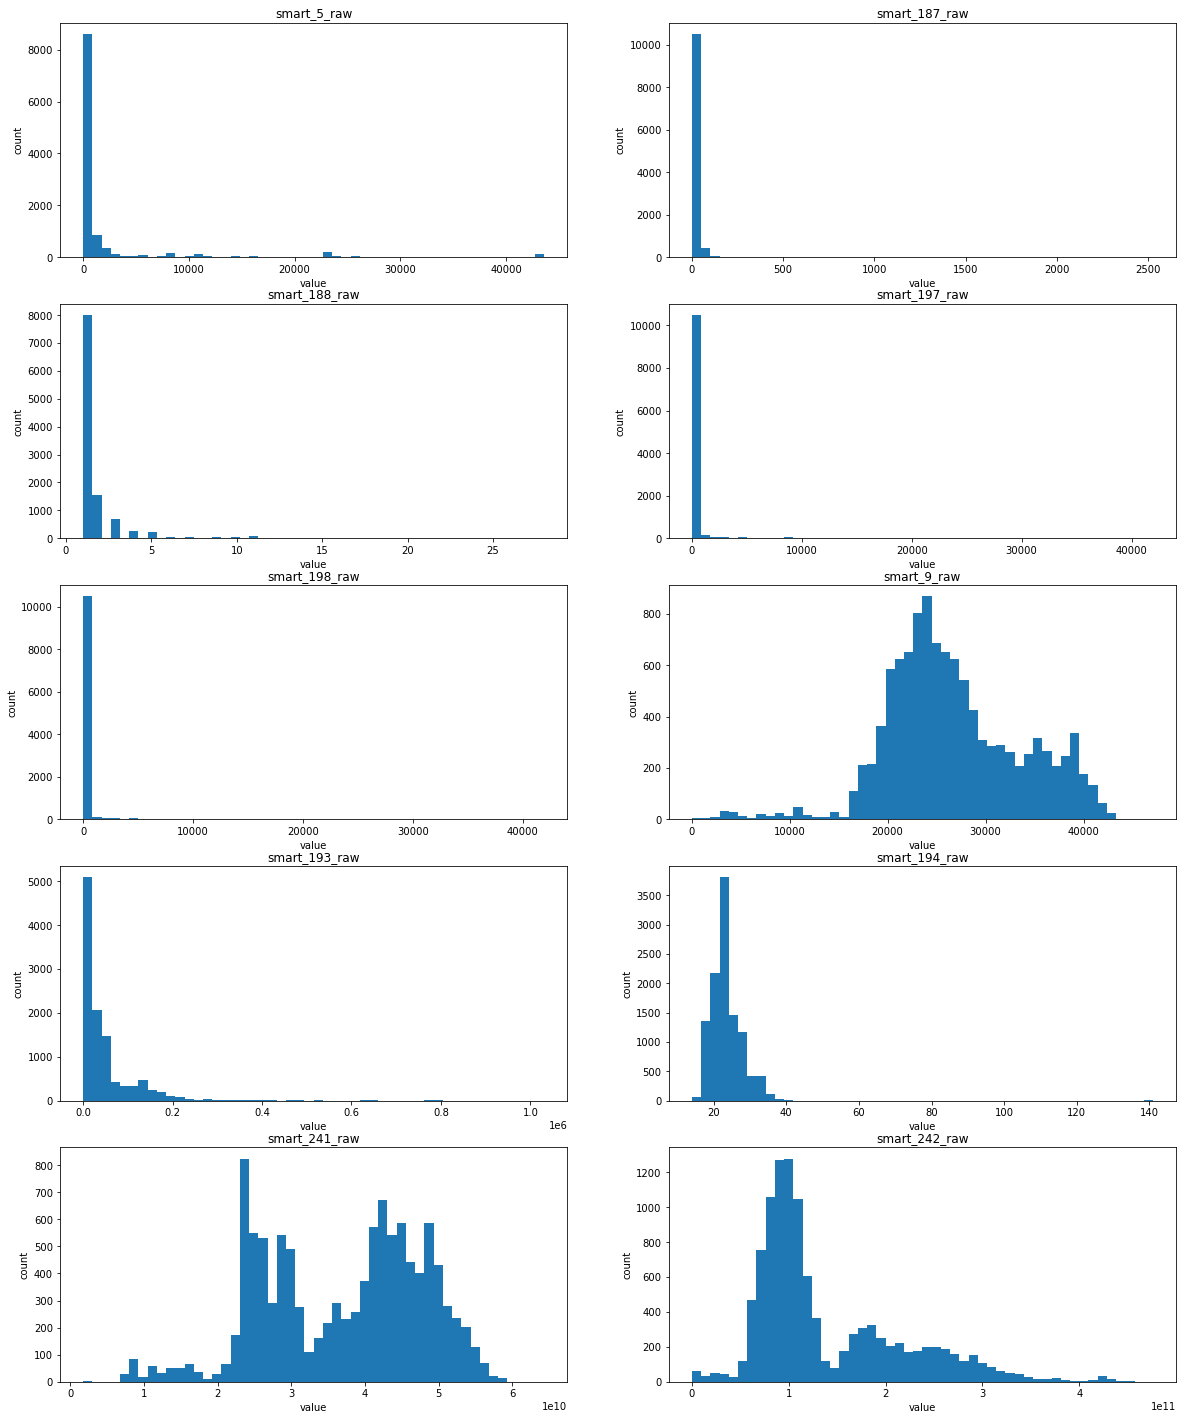

In [516]:
hist_attribute(X,bin=50)

In [526]:
# 对数优化
X['smart_5_raw']=X['smart_5_raw'].apply(np.log)
X['smart_187_raw']=X['smart_187_raw'].apply(np.log)
X['smart_188_raw']=X['smart_188_raw'].apply(np.log)
X['smart_197_raw']=X['smart_197_raw'].apply(np.log)
X['smart_198_raw']=X['smart_198_raw'].apply(np.log)
X['smart_193_raw']=X['smart_193_raw'].apply(np.log)

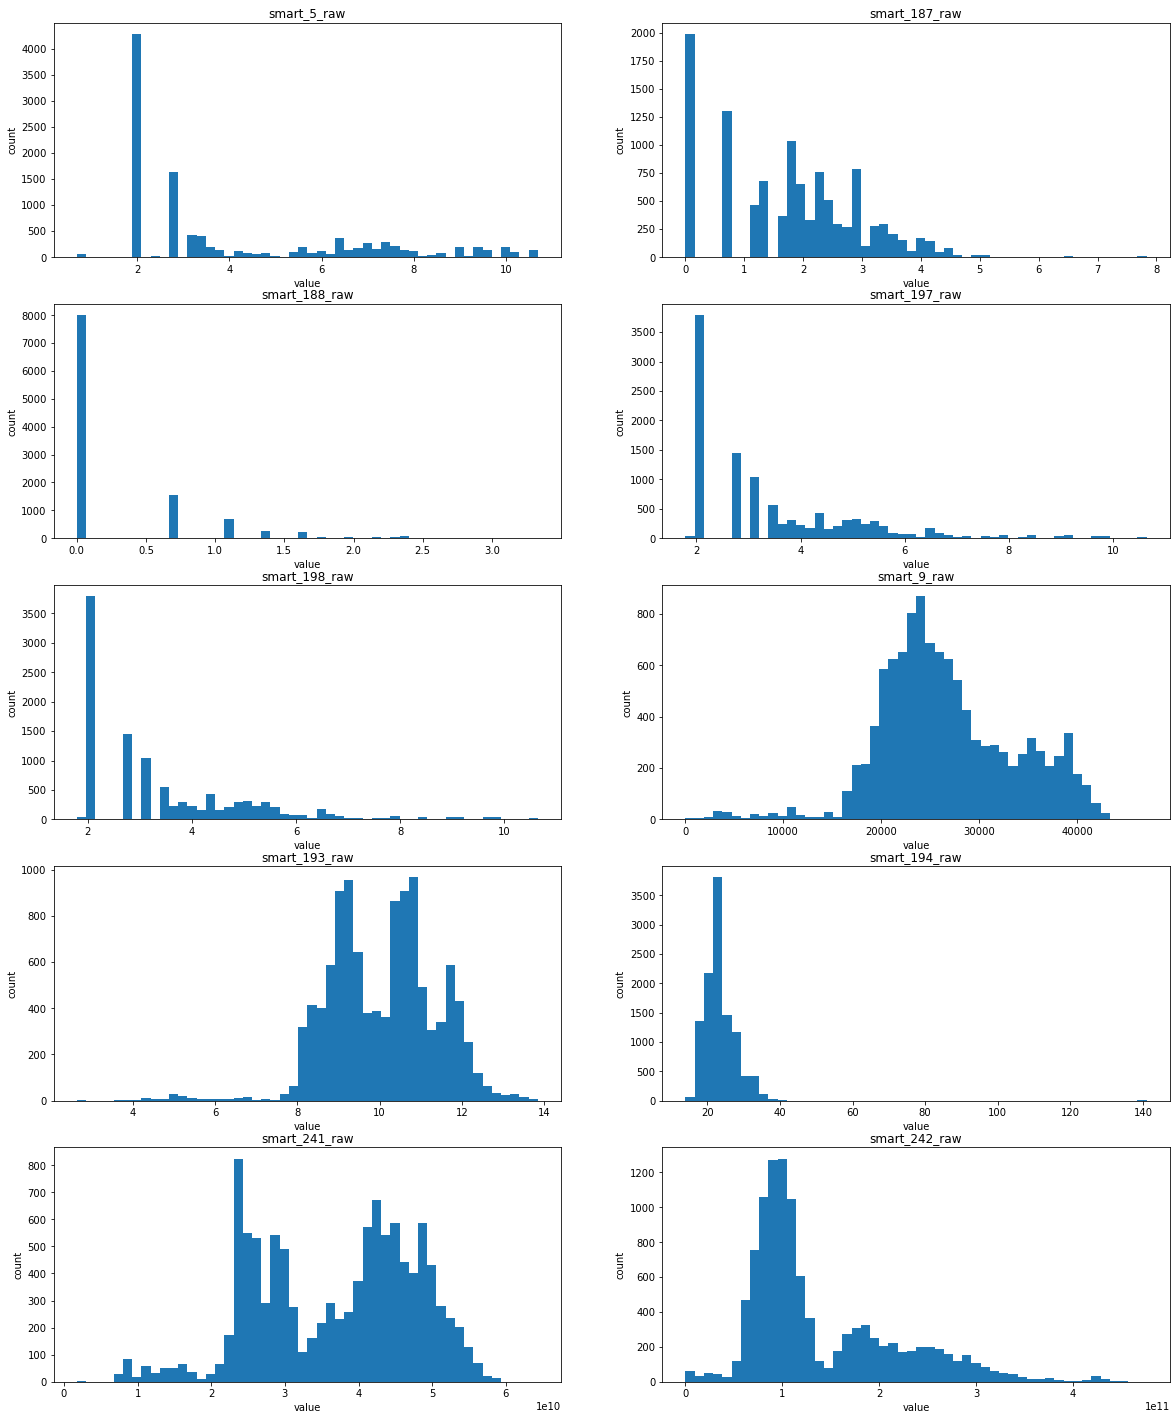

In [530]:
%matplotlib inline
hist_attribute(X,bin=50)

In [542]:
# 归一化
from sklearn.preprocessing import StandardScaler

ss=StandardScaler()
X_knn=ss.fit_transform(X)
y_knn=np.array(Y.values).reshape(-1,1)

In [543]:
# 降维可视化
%matplotlib auto
plot_pca(num=3,data=X_knn,label=y_knn)

Using matplotlib backend: Qt5Agg


In [544]:
clf_1 = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
clf_2 = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
clf_3 = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

scores1 = cross_val_score(clf_1, X_knn, y_knn, cv=5)
scores2 = cross_val_score(clf_2, X_knn, y_knn, cv=5)
scores3 = cross_val_score(clf_3, X_knn, y_knn, cv=5)

print('RandomForestClassifier scores: ',scores1.mean())
print('DecisionTreeClassifier scores: ',scores2.mean())
print('ExtraTreesClassifier scores: ',scores3.mean())

RandomForestClassifier scores:  0.5258722247394654
DecisionTreeClassifier scores:  0.5202537381060263
ExtraTreesClassifier scores:  0.5188944268237428
